In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, 
                                AutoLocator, MaxNLocator)
from matplotlib import rcParams
from matplotlib import patches
import scipy.io
import astropy.constants as const
import importlib
import juanfit
importlib.reload(juanfit)
from juanfit import SpectrumFitSingle,SpectrumFitRow, gaussian
import copy
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import simps
from scipy.signal import find_peaks
rcParams['axes.linewidth'] = 1.5
import cmcrameri.cm as cmcm
import h5py
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval,\
         ManualInterval, SqrtStretch
import corner

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
awsom_data_set = scipy.io.readsav(r'../../sav/AWSoM/streamer_test/box_run0017_run03_75.sav',verbose = True,python_dict=True)

--------------------------------------------------
Date: Mon Nov 21 11:04:02 2022
User: yjzhu
Host: 0587449807.wireless.umich.net
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 6 records of which:
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
 - 3 are of type VARIABLE
--------------------------------------------------
Available variables:
 - x [<class 'numpy.ndarray'>]
 - w [<class 'numpy.ndarray'>]
 - param [<class 'numpy.ndarray'>]
--------------------------------------------------


In [4]:
m_p = const.m_p.cgs.value
k_b = const.k_B.cgs.value
c = const.c.cgs.value
rs = const.R_sun.cgs.value
amu = const.u.cgs.value

In [5]:
p_e_ratio = 0.83
awsom_x = awsom_data_set['x'][0,0,0,:]
awsom_y = awsom_data_set['x'][1,0,:,0]
awsom_z = awsom_data_set['x'][2,:,0,0]
awsom_x_grid = awsom_data_set['x'][0,:,:,:]
awsom_y_grid = awsom_data_set['x'][1,:,:,:]
awsom_z_grid = awsom_data_set['x'][2,:,:,:]
rho = awsom_data_set['w'][0,:,:,:]
n = rho/m_p
#n = np.nan_to_num(n,nan=0)
ux = awsom_data_set['w'][1,:,:,:]
uy = awsom_data_set['w'][2,:,:,:]
uz = awsom_data_set['w'][3,:,:,:]
bx = awsom_data_set['w'][4,:,:,:]
by = awsom_data_set['w'][5,:,:,:]
bz = awsom_data_set['w'][6,:,:,:]
I01 = awsom_data_set['w'][7,:,:,:]
I02 = awsom_data_set['w'][8,:,:,:]
p = awsom_data_set['w'][9,:,:,:]
t_p = p/n/k_b
#t = np.nan_to_num(t,nan=1e3)
p_e = awsom_data_set['w'][10,:,:,:]
t_e = p_e/n/k_b
# t_e = np.nan_to_num(t_e,nan=1e3)
# n = np.nan_to_num(n,nan=1)
# n = n + 1
p_par = awsom_data_set['w'][11,:,:,:]
t_par = p_par/n/k_b
t_perp = (3*t_p - t_par)/2.
b_tot = np.sqrt(np.square(bx) + np.square(by) + np.square(bz))
u_tot = np.sqrt(np.square(ux) + np.square(uy) + np.square(uz))
bx_rot = np.zeros_like(bx)
by_rot = np.zeros_like(by)
bz_rot = np.zeros_like(bz)
ux_rot = np.zeros_like(ux)
uy_rot = np.zeros_like(uy)
uz_rot = np.zeros_like(uz)

rot_DD = np.resize(awsom_data_set["param"],(3,3))
for ii in range(ux.shape[0]):
    for jj in range(ux.shape[1]):
        for kk in range(ux.shape[2]):
            bx_rot[ii,jj,kk],by_rot[ii,jj,kk],bz_rot[ii,jj,kk] = np.matmul([bx[ii,jj,kk],by[ii,jj,kk],bz[ii,jj,kk]],rot_DD.T)
            ux_rot[ii,jj,kk],uy_rot[ii,jj,kk],uz_rot[ii,jj,kk] = np.matmul([ux[ii,jj,kk],uy[ii,jj,kk],uz[ii,jj,kk]],rot_DD.T)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/823917285.py:20: RuntimeWarning: invalid value encountered in divide
  t_p = p/n/k_b
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/823917285.py:23: RuntimeWarning: invalid value encountered in divide
  t_e = p_e/n/k_b
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/823917285.py:28: RuntimeWarning: invalid value encountered in divide
  t_par = p_par/n/k_b


In [121]:
ux.shape

(169, 96, 301)

In [6]:
chianti_emiss_tbl = scipy.io.readsav("../../sav/AWSoM/chianti_table/AWSoM_UCoMP_emiss.sav",verbose=True,python_dict=True)

--------------------------------------------------
Date: Mon Nov 21 08:21:02 2022
User: Yingjie
Host: DESKTOP-8RK6URI
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: Win32
IDL Version: 8.5
--------------------------------------------------
Successfully read 16 records of which:
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
 - 13 are of type VARIABLE
--------------------------------------------------
Available variables:
 - fexiv_emiss_array [<class 'numpy.ndarray'>]
 - fex_emiss_array [<class 'numpy.ndarray'>]
 - fexi_emiss_array [<class 'numpy.ndarray'>]
 - fexiii_10747_emiss_array [<class 'numpy.ndarray'>]
 - fexiii_10798_emiss_array [<class 'numpy.ndarray'>]
 - fexv_emiss_array [<class 'numpy.ndarray'>]
 - sviii_emiss_array [<class 'numpy.ndarray'>]
 - sxii_emiss_array [<class 'numpy.ndarray'>]
 - nixv_6703_emiss_array [<class 'numpy.ndarray'>]
 - nixv_8026_emiss_array [<class 'numpy.ndarray'>]
 - temp [<class 'numpy.ndarray

In [7]:
height_grid = np.sqrt(awsom_x_grid**2 + awsom_y_grid**2 + awsom_z_grid**2)

In [8]:
FeXIV_emiss_func = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fexiv_emiss_array"],
                    bounds_error=False,method="linear")
FeXIV_emiss_box = FeXIV_emiss_func((height_grid[:,:,:], np.log10(n[:,:,:]), np.log10(t_e[:,:,:])))

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/3913028072.py:4: RuntimeWarning: divide by zero encountered in log10
  FeXIV_emiss_box = FeXIV_emiss_func((height_grid[:,:,:], np.log10(n[:,:,:]), np.log10(t_e[:,:,:])))


In [9]:
def compare_interp(param,table,linear_func,cubic_func=None,logcubic_func=None,height_index=None,dens_index=None,temp_index=None):
    x_points = table[param]
    x_points_to_plot = np.linspace(x_points[0],x_points[-1],201)
    if param == "height":
        table_cut = table["fexiv_emiss_array"][:,dens_index,temp_index]
        dens = table["dens"][dens_index]*np.ones(201)
        temp = table["temp"][temp_index]*np.ones(201)
        linear_fit = linear_func((x_points_to_plot,dens,temp))
        # cubic_fit = cubic_func((x_points_to_plot,dens,temp))
        # logcubic_fit = np.power(10,logcubic_func((x_points_to_plot,dens,temp)))
        title = r"$\log N_e: {:.2f} \log T_e {:.2f}$".format(dens[0],temp[0])
    elif param == "dens":
        table_cut = table["fexiv_emiss_array"][height_index,:,temp_index]
        height = table["height"][height_index]*np.ones(201)
        temp = table["temp"][temp_index]*np.ones(201)
        linear_fit = linear_func((height,x_points_to_plot,temp))
        # cubic_fit = cubic_func((height,x_points_to_plot,temp))
        # logcubic_fit = np.power(10,logcubic_func((height,x_points_to_plot,temp)))
        title = r"$R_\odot {:.2f} \log T_e {:.2f}$".format(height[0],temp[0])
    elif param == "temp":
        table_cut = table["fexiv_emiss_array"][height_index,dens_index,:]
        dens = table["dens"][dens_index]*np.ones(201)
        height = table["height"][height_index]*np.ones(201)
        linear_fit = linear_func((height,dens,x_points_to_plot))
        # cubic_fit = cubic_func((height,dens,x_points_to_plot))
        # logcubic_fit = np.power(10,logcubic_func((height,dens,x_points_to_plot)))
        title = r"$R_\odot {:.2f} \log N_e: {:.2f}$".format(height[0],dens[0])
    
    fig, ax = plt.subplots(figsize=(6,4),constrained_layout=True)
    ax.scatter(x_points,table_cut)
    ax.plot(x_points_to_plot,linear_fit,label="linear")
    # ax.plot(x_points_to_plot,cubic_fit,label="cubic")
    # ax.plot(x_points_to_plot,logcubic_fit,label="logcubic")
    ax.legend(fontsize=14,frameon=False)
    ax.set_xlabel(param,fontsize=14)
    ax.tick_params(labelsize=14)
    ax.set_yscale("log")
    ax.set_title(title,fontsize=14)

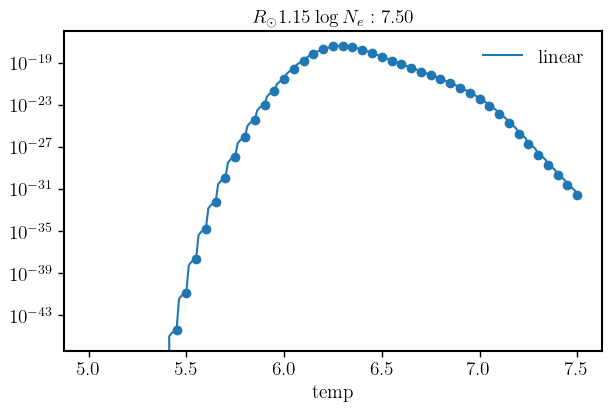

In [10]:
compare_interp("temp",chianti_emiss_tbl,FeXIV_emiss_func,height_index=3,dens_index=10)

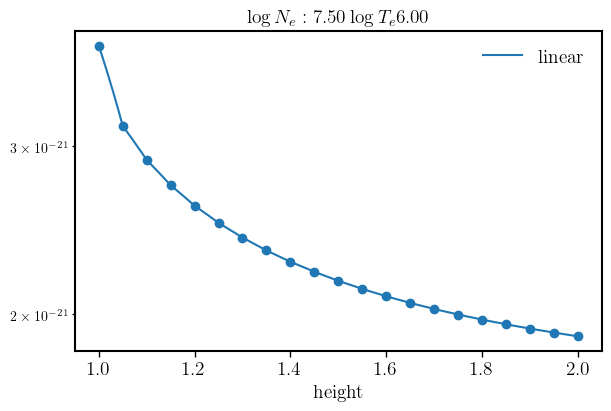

In [11]:
compare_interp("height",chianti_emiss_tbl,FeXIV_emiss_func,temp_index=20,dens_index=10)

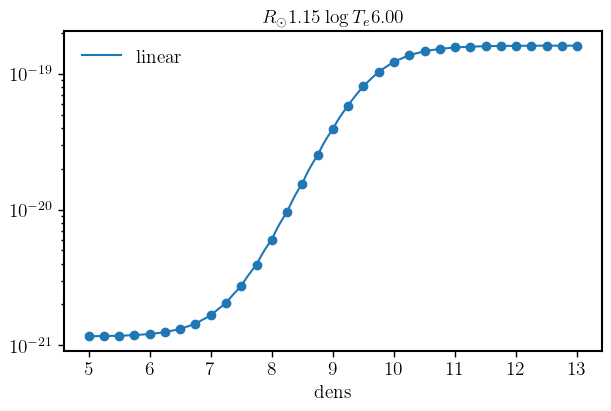

In [12]:
compare_interp("dens",chianti_emiss_tbl,FeXIV_emiss_func,temp_index=20,height_index=3,
                )

In [13]:
FeX_emiss_func = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fex_emiss_array"],
                    bounds_error=False,method="linear")
FeX_emiss_box = FeX_emiss_func((height_grid[:,:,:], np.log10(n[:,:,:]), np.log10(t_e[:,:,:])))

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/174913436.py:4: RuntimeWarning: divide by zero encountered in log10
  FeX_emiss_box = FeX_emiss_func((height_grid[:,:,:], np.log10(n[:,:,:]), np.log10(t_e[:,:,:])))


In [14]:
awsom_on_disk_yz_index = np.where(np.sqrt(awsom_y_grid[:,:,150]**2 + awsom_z_grid[:,:,150]**2) <= 1) 
awsom_off_limb_yz_index = np.where(np.sqrt(awsom_y_grid[:,:,150]**2 + awsom_z_grid[:,:,150]**2) > 1) 

In [15]:
FeXIV_int_nearside = np.nansum((FeXIV_emiss_box*n)[:,:,150:]*0.01*const.R_sun.cgs.value,axis=2)
FeXIV_int_farside = np.nansum((FeXIV_emiss_box*n)[:,:,:150]*0.01*const.R_sun.cgs.value,axis=2)
FeXIV_int = np.zeros(FeXIV_emiss_box.shape[:-1])
FeXIV_int[awsom_off_limb_yz_index] = (FeXIV_int_nearside + FeXIV_int_farside)[awsom_off_limb_yz_index]
FeXIV_int[awsom_on_disk_yz_index] = FeXIV_int_nearside[awsom_on_disk_yz_index]

In [16]:
FeX_int_nearside = np.nansum((FeX_emiss_box*n)[:,:,150:]*0.01*const.R_sun.cgs.value,axis=2)
FeX_int_farside = np.nansum((FeX_emiss_box*n)[:,:,:150]*0.01*const.R_sun.cgs.value,axis=2)
FeX_int = np.zeros(FeX_emiss_box.shape[:-1])
FeX_int[awsom_off_limb_yz_index] = (FeX_int_nearside + FeX_int_farside)[awsom_off_limb_yz_index]
FeX_int[awsom_on_disk_yz_index] = FeX_int_nearside[awsom_on_disk_yz_index]

In [17]:
def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                        facecolor="none",alpha=0.6,ls="--")

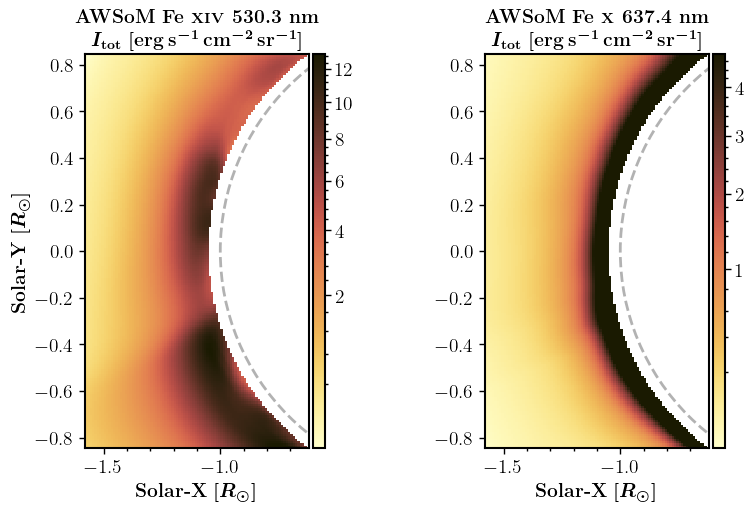

In [18]:
mask_transition_region = np.where(np.sqrt(awsom_y_grid[:,:,150]**2 + awsom_z_grid[:,:,150]**2) <= 1.05) 
FeXIV_int_mask_TR = np.copy(FeXIV_int)
FeXIV_int_mask_TR[mask_transition_region] = np.nan
FeX_int_mask_TR = np.copy(FeX_int)
FeX_int_mask_TR[mask_transition_region] = np.nan

fig, axes = plt.subplots(1,2,figsize=(8,5),constrained_layout=True)
norm_FeXIV_int_mask_TR = ImageNormalize(FeXIV_int_mask_TR,interval=ZScaleInterval(),stretch=SqrtStretch())
im_FeXIV = axes[0].pcolormesh(awsom_y,awsom_z, FeXIV_int_mask_TR,norm=norm_FeXIV_int_mask_TR, cmap=cmcm.lajolla, shading="auto",rasterized=True)
plot_colorbar(im_FeXIV,axes[0],width="5%")
axes[0].set_title(r"\textbf{AWSoM Fe \textsc{xiv} 530.3 nm}" + "\n" + \
                    r"$\boldsymbol{I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}}$",fontsize=14)

norm_FeX_int_mask_TR = ImageNormalize(FeX_int_mask_TR,interval=ZScaleInterval(),stretch=SqrtStretch())
im_FeX = axes[1].pcolormesh(awsom_y,awsom_z, FeX_int_mask_TR,norm=norm_FeX_int_mask_TR, cmap=cmcm.lajolla, shading="auto",rasterized=True)
plot_colorbar(im_FeX,axes[1],width="5%")
axes[1].set_title(r"\textbf{AWSoM Fe \textsc{x} 637.4 nm}" + "\n" + \
                    r"$\boldsymbol{I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}}$",fontsize=14)

axes[0].set_ylabel(r"\textbf{Solar-Y} $\boldsymbol{[R_\odot]}$",fontsize=14)
xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.xaxis.set_minor_locator(AutoMinorLocator())
    ax_.add_patch(create_limb_circle(1))
    ax_.set_xlabel(r"\textbf{Solar-X} $\boldsymbol{[R_\odot]}$",fontsize=14)
    ax_.set_xlim(xlim)
    ax_.set_ylim(ylim)


In [19]:
def calc_intensity(emiss_table,dens,temp,height,height_grid,dens_grid,te_grid,
                    off_limb_yz_index, on_disk_yz_index,pos_xindex=150,method="linear",p_to_e=0.83):
    emiss_func = interpolate.RegularGridInterpolator(points=(height,dens,temp),
                    values=emiss_table,
                    bounds_error=False,method=method)
    emiss_box = emiss_func((height_grid[:,:,:], np.log10(dens_grid[:,:,:])/p_to_e, np.log10(te_grid[:,:,:])))
    
    int_tot = np.nansum((emiss_box*dens_grid)[:,:,:]*0.01*const.R_sun.cgs.value,axis=2)
    int_tot[on_disk_yz_index] = int_tot[on_disk_yz_index] - \
                    np.nansum((emiss_box*dens_grid)[:,:,:pos_xindex]*0.01*const.R_sun.cgs.value,axis=2)[on_disk_yz_index]
    # int_nearside = np.nansum((emiss_box*dens_grid)[:,:,150:]*0.01*const.R_sun.cgs.value,axis=2)
    # int_farside = np.nansum((emiss_box*dens_grid)[:,:,:150]*0.01*const.R_sun.cgs.value,axis=2)
    # int_tot = np.zeros(emiss_box.shape[:-1])
    # int_tot[off_limb_yz_index] = (int_nearside + int_farside)[off_limb_yz_index]
    # int_tot[on_disk_yz_index] = int_nearside[on_disk_yz_index]

    return int_tot

In [20]:
emiss_calc_common_params = (chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"],chianti_emiss_tbl["height"],
                height_grid, n, t_e, awsom_off_limb_yz_index, awsom_on_disk_yz_index)

FeXI_int = calc_intensity(chianti_emiss_tbl["fexi_emiss_array"],*emiss_calc_common_params)
FeXIII_10747_int = calc_intensity(chianti_emiss_tbl["fexiii_10747_emiss_array"],*emiss_calc_common_params)
FeXIII_10798_int = calc_intensity(chianti_emiss_tbl["fexiii_10798_emiss_array"],*emiss_calc_common_params)
FeXV_int = calc_intensity(chianti_emiss_tbl["fexv_emiss_array"],*emiss_calc_common_params)
SVIII_int = calc_intensity(chianti_emiss_tbl["sviii_emiss_array"],*emiss_calc_common_params)
SXII_int = calc_intensity(chianti_emiss_tbl["sxii_emiss_array"],*emiss_calc_common_params)
NiXV_6703_int = calc_intensity(chianti_emiss_tbl["nixv_6703_emiss_array"],*emiss_calc_common_params)
NiXV_8026_int = calc_intensity(chianti_emiss_tbl["nixv_8026_emiss_array"],*emiss_calc_common_params)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/2516017324.py:6: RuntimeWarning: divide by zero encountered in log10
  emiss_box = emiss_func((height_grid[:,:,:], np.log10(dens_grid[:,:,:])/p_to_e, np.log10(te_grid[:,:,:])))


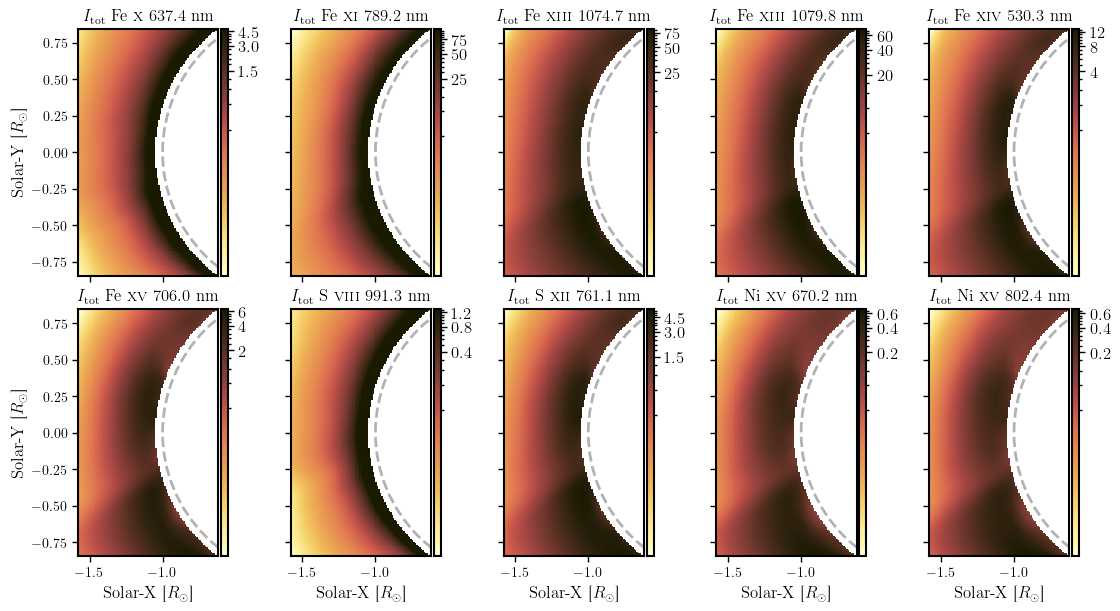

In [21]:
fig, axes = plt.subplots(2,5,figsize=(11,6),constrained_layout=True)

UCoMP_int_arrays = [FeX_int, FeXI_int, FeXIII_10747_int, FeXIII_10798_int, FeXIV_int,
                     FeXV_int, SVIII_int, SXII_int, NiXV_6703_int, NiXV_8026_int]

titles = [r'Fe \textsc{x} 637.4 nm',r'Fe \textsc{xi} 789.2 nm',
            r'Fe \textsc{xiii} 1074.7 nm',r'Fe \textsc{xiii} 1079.8 nm',
            r'Fe \textsc{xiv} 530.3 nm', r'Fe \textsc{xv} 706.0 nm',
            r'S \textsc{viii} 991.3 nm', r'S \textsc{xii} 761.1 nm',
            r'Ni \textsc{xv} 670.2 nm',r'Ni \textsc{xv} 802.4 nm']

for ii, (ax_, UCoMP_int_array_, title_) in enumerate(zip(axes.flatten(),UCoMP_int_arrays, titles)):
    int_mask_TR = np.copy(UCoMP_int_array_)
    int_mask_TR[mask_transition_region] = np.nan
    norm_int_mask_TR = ImageNormalize(int_mask_TR,interval=ZScaleInterval(),stretch=LogStretch())

    im_ = ax_.pcolormesh(awsom_y,awsom_z, int_mask_TR,norm=norm_int_mask_TR, cmap=cmcm.lajolla, shading="auto",rasterized=True)
    clb, clb_ax = plot_colorbar(im_,ax_,width="5%",fontsize=12)
    clb_ax.yaxis.set_major_locator(MaxNLocator(4))
    ax_.set_title(r"$I_{\rm tot}$\ " + title_,fontsize=12)

    if ii < 5:
        ax_.tick_params(labelbottom=False)
    else:
        ax_.set_xlabel('Solar-X [$R_\odot$]',fontsize=12)
    if ii%5 != 0:
        ax_.tick_params(labelleft=False)
    else:
        ax_.set_ylabel('Solar-Y [$R_\odot$]',fontsize=12)
    ax_xlim = ax_.get_xlim()
    ax_ylim = ax_.get_ylim()
    ax_.set_aspect(1)
    ax_.add_patch(create_limb_circle(1))
    ax_.set_xlim(ax_xlim)
    ax_.set_ylim(ax_ylim)
     

In [39]:
def calc_profile(emiss_table,dens,temp,height,height_grid,dens_grid,te_grid,tp_grid,
                    vlos_grid, vnt2_grid, wvl_grid, rest_wvl,ion_mass_amu,
                    off_limb_yz_index, on_disk_yz_index,pos_xindex=150,method="linear",return_emiss=False,
                    p_to_e=0.83):
    emiss_func = interpolate.RegularGridInterpolator(points=(height,dens,temp),
                    values=emiss_table,
                    bounds_error=False,method=method)
    emiss_box = emiss_func((height_grid[:,:,:], np.log10(dens_grid[:,:,:])/p_to_e, np.log10(te_grid[:,:,:])))* \
        (dens_grid/p_to_e)*0.01*const.R_sun.cgs.value

    veff_grid = np.sqrt(2*k_b*tp_grid/ion_mass_amu/amu + vnt2_grid)
    line_wvl_grid = rest_wvl*(1 - vlos_grid/c)
    fwhm_grid = np.sqrt(4*np.log(2))*rest_wvl*veff_grid/c

    line_profile_grid = gaussian(wvl=wvl_grid[np.newaxis,np.newaxis,np.newaxis,:], line_wvl=line_wvl_grid[:,:,:,np.newaxis],
                int_total=emiss_box[:,:,:,np.newaxis], fwhm=fwhm_grid[:,:,:,np.newaxis])

    profile_integrated = np.nansum(line_profile_grid[:,:,:,:],axis=2)
    profile_integrated[on_disk_yz_index] = profile_integrated[on_disk_yz_index] - \
        np.nansum(line_profile_grid[:,:,:pos_xindex,:],axis=2)[on_disk_yz_index]

    if return_emiss:
        return profile_integrated, emiss_box
    else:
        return profile_integrated

In [35]:
cos_alpha = bx_rot/b_tot
sin_alpha = np.sqrt(1 - cos_alpha**2)

vnt2 = 0.5*(I01 + I02)/m_p/n*sin_alpha**2 
tlos = t_perp*sin_alpha**2 + t_par*cos_alpha**2

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/3848654694.py:1: RuntimeWarning: invalid value encountered in divide
  cos_alpha = bx_rot/b_tot
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/3848654694.py:4: RuntimeWarning: invalid value encountered in divide
  vnt2 = 0.5*(I01 + I02)/m_p/n*sin_alpha**2


In [68]:
FeXIV_wvl_grid = np.linspace(530.,530.6,26)
FeXIV_rest_wvl = 530.286
Fe_amu = 55.85
FeXIV_profiles = calc_profile(chianti_emiss_tbl["fexiv_emiss_array"], chianti_emiss_tbl["dens"],
                        chianti_emiss_tbl["temp"],chianti_emiss_tbl["height"],height_grid, n, t_e,
                        tlos,ux_rot*1e5,vnt2,FeXIV_wvl_grid,FeXIV_rest_wvl,Fe_amu,awsom_off_limb_yz_index,
                         awsom_on_disk_yz_index)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/2749723670.py:8: RuntimeWarning: divide by zero encountered in log10
  emiss_box = emiss_func((height_grid[:,:,:], np.log10(dens_grid[:,:,:])/p_to_e, np.log10(te_grid[:,:,:])))* \


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot: ylabel='Intensity'>

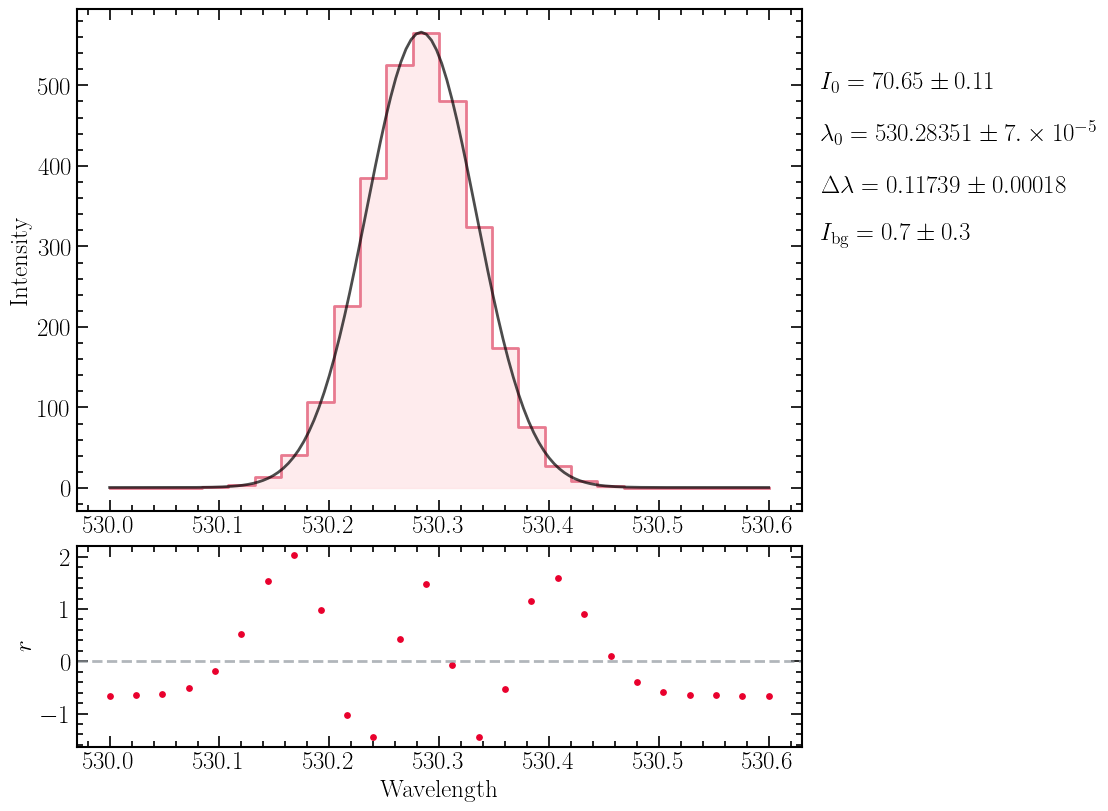

In [40]:
FeXIV_peek_index = (10,40)
FeXIV_peek_model = SpectrumFitSingle(FeXIV_profiles[FeXIV_peek_index[0],FeXIV_peek_index[1],:],FeXIV_wvl_grid, line_number=1,
                                line_wvl_init=530.28,int_max_init=np.max(FeXIV_profiles[FeXIV_peek_index[0],FeXIV_peek_index[1],:]),
                                fwhm_init=0.1)
FeXIV_peek_model.run_lse()
FeXIV_peek_model.plot()

In [42]:
FeXIV_fit_matrix = np.full_like(FeXIV_profiles[:,:,:4],np.nan)
FeXIV_err_matrix = np.full_like(FeXIV_profiles[:,:,:4],np.nan)
for ii in range(FeXIV_profiles.shape[1]):
    fit_row_model = SpectrumFitRow(FeXIV_profiles[:,ii,:],FeXIV_wvl_grid,line_number=1,line_wvl_init=530.28,
                                    int_max_init=100,fwhm_init=0.1)
    
    fit_row_model.run_lse()
    FeXIV_fit_matrix[:,ii,0] = fit_row_model.line_wvl_fit[:,0]
    FeXIV_err_matrix[:,ii,0] = fit_row_model.line_wvl_err[:,0]
    FeXIV_fit_matrix[:,ii,1] = fit_row_model.int_total_fit[:,0]
    FeXIV_err_matrix[:,ii,1] = fit_row_model.int_total_err[:,0]
    FeXIV_fit_matrix[:,ii,2] = fit_row_model.fwhm_fit[:,0]
    FeXIV_err_matrix[:,ii,2] = fit_row_model.fwhm_err[:,0]
    FeXIV_fit_matrix[:,ii,3] = fit_row_model.int_cont_fit[:]
    FeXIV_err_matrix[:,ii,3] = fit_row_model.int_cont_err[:]

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:205: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


In [58]:
FeXIV_fit_matrix[:,:,1]

array([[  7.10560403,   7.45969402,   7.84671558, ..., 155.70505065,
        142.04499497, 131.8410101 ],
       [  7.32005898,   7.68335985,   8.08747874, ..., 142.61656796,
        134.52856727, 128.41800685],
       [  7.52331242,   7.89681574,   8.32389907, ..., 137.64855736,
        132.54140282, 128.10961342],
       ...,
       [  0.4671103 ,   0.51877977,   0.58278075, ...,  82.71594221,
         81.49106799,  80.65699346],
       [  0.43872175,   0.48841751,   0.55042033, ...,  84.7543255 ,
         83.21042031,  82.16430751],
       [  0.41103686,   0.45859533,   0.51893643, ...,  85.16467699,
         83.79235682,  82.73412938]])

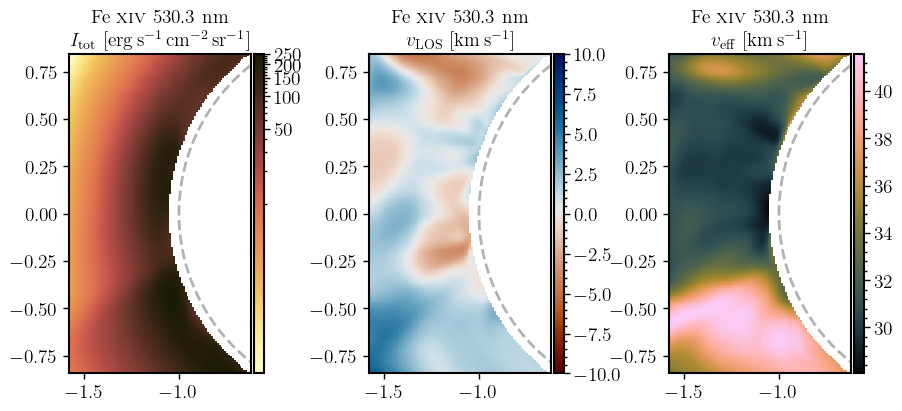

In [89]:
fig, axes = plt.subplots(1,3,figsize=(9,4),constrained_layout=True)

FeXIV_matrix_mask_TR = np.copy(FeXIV_fit_matrix)
mask_transition_region_fit = np.where(np.sqrt(awsom_y_grid[:,:,150]**2 + awsom_z_grid[:,:,150]**2)[:,:,np.newaxis]* \
                        np.ones_like(FeXIV_matrix_mask_TR) <= 1.05) 
FeXIV_matrix_mask_TR[mask_transition_region_fit] = np.nan

norm_FeXIV_matrix_int_mask_TR = ImageNormalize(FeXIV_matrix_mask_TR[:,:,1],interval=ZScaleInterval(),stretch=LogStretch())

im_int = axes[0].pcolormesh(awsom_y,awsom_z, FeXIV_matrix_mask_TR[:,:,1],norm=norm_FeXIV_matrix_int_mask_TR,
 cmap=cmcm.lajolla, shading="auto",rasterized=True)
axes[0].set_title(r"Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=14)
plot_colorbar(im_int, axes[0],width="5%")

im_vlos = axes[1].pcolormesh(awsom_y,awsom_z, (1 - FeXIV_matrix_mask_TR[:,:,0]/FeXIV_rest_wvl)*c/1e5,vmin=-10,vmax=10,
 cmap=cmcm.vik_r, shading="auto",rasterized=True)
axes[1].set_title(r"Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
plot_colorbar(im_vlos, axes[1],width="5%")

im_veff = axes[2].pcolormesh(awsom_y,awsom_z, FeXIV_matrix_mask_TR[:,:,2]/FeXIV_rest_wvl/np.sqrt(4*np.log(2))*c/1e5,
 cmap=cmcm.batlowK, shading="auto",rasterized=True)
axes[2].set_title(r"Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
plot_colorbar(im_veff, axes[2],width="5%")

for ax_ in axes:
    ax_xlim = ax_.get_xlim()
    ax_ylim = ax_.get_ylim()
    ax_.set_aspect(1)
    ax_.add_patch(create_limb_circle(1))
    ax_.set_xlim(ax_xlim)
    ax_.set_ylim(ax_ylim)
    ax_.tick_params(labelsize=14)
 

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_54749/4284047170.py:3: RuntimeWarning: divide by zero encountered in log10
  im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK,


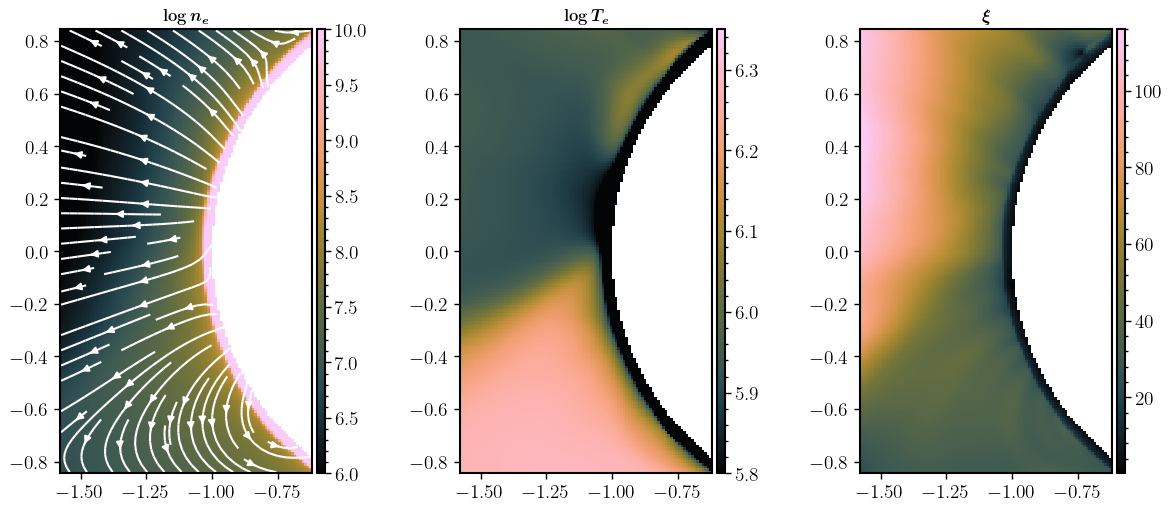

In [100]:
fig, axes = plt.subplots(1,3,figsize=(12,5),constrained_layout=True)
index_los = 150
im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=6,vmax=10,shading="auto",rasterized=True)
axes[0].set_title(r"$\boldsymbol{\log n_e}$")
plot_colorbar(im_n,axes[0])
axes[0].streamplot(awsom_y,awsom_z,by_rot[:,:,index_los],bz_rot[:,:,index_los],
color="white")

im_te = axes[1].pcolormesh(awsom_y,awsom_z, np.log10(t_e[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_te,axes[1])
axes[1].set_title(r"$\boldsymbol{\log T_e}$")
im_tp = axes[2].pcolormesh(awsom_y,awsom_z, np.sqrt(vnt2[:,:,index_los])/1e5, cmap=cmcm.batlowK, 
                shading="auto",rasterized=True)
plot_colorbar(im_tp,axes[2])
axes[2].set_title(r"$\boldsymbol{\xi}$")
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_9550/231902834.py:3: RuntimeWarning: divide by zero encountered in log10
  im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK,


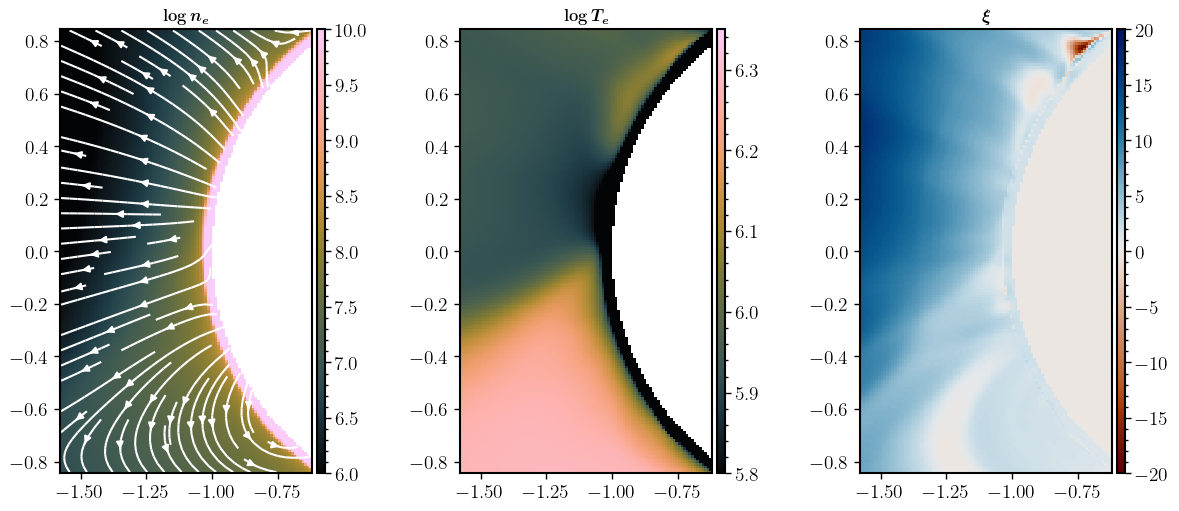

In [120]:
fig, axes = plt.subplots(1,3,figsize=(12,5),constrained_layout=True)
index_los = 150
im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=6,vmax=10,shading="auto",rasterized=True)
axes[0].set_title(r"$\boldsymbol{\log n_e}$")
plot_colorbar(im_n,axes[0])
axes[0].streamplot(awsom_y,awsom_z,by_rot[:,:,index_los],bz_rot[:,:,index_los],
color="white")

im_te = axes[1].pcolormesh(awsom_y,awsom_z, np.log10(t_e[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_te,axes[1])
axes[1].set_title(r"$\boldsymbol{\log T_e}$")
im_tp = axes[2].pcolormesh(awsom_y,awsom_z, ux_rot[:,:,index_los], cmap=cmcm.vik_r, 
                shading="auto",rasterized=True,vmin=-20,vmax=20)
plot_colorbar(im_tp,axes[2])
axes[2].set_title(r"$\boldsymbol{\xi}$")
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_54749/4256795501.py:3: RuntimeWarning: divide by zero encountered in log10
  im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK,


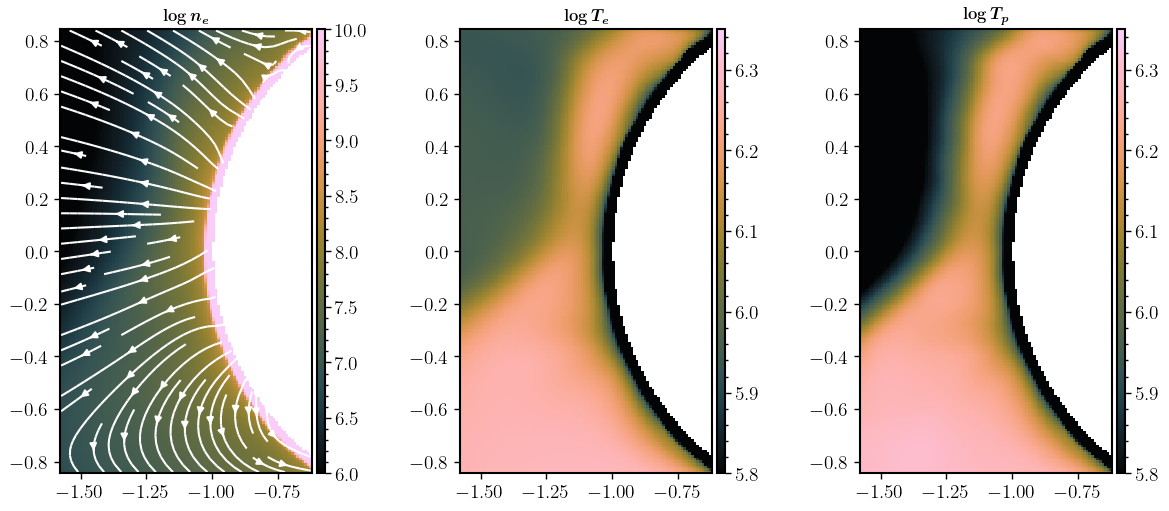

In [69]:
fig, axes = plt.subplots(1,3,figsize=(12,5),constrained_layout=True)
index_los = 160
im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=6,vmax=10,shading="auto",rasterized=True)
axes[0].set_title(r"$\boldsymbol{\log n_e}$")
plot_colorbar(im_n,axes[0])
axes[0].streamplot(awsom_y,awsom_z,by_rot[:,:,index_los],bz_rot[:,:,index_los],
color="white")

im_te = axes[1].pcolormesh(awsom_y,awsom_z, np.log10(t_e[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_te,axes[1])
axes[1].set_title(r"$\boldsymbol{\log T_e}$")
im_tp = axes[2].pcolormesh(awsom_y,awsom_z, np.log10(t_p[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_tp,axes[2])
axes[2].set_title(r"$\boldsymbol{\log T_p}$")

axes[0].set_ylim(axes[1].get_ylim())
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)